# Week 1: Loading and Exploring NWB Data

This notebook introduces how to load and explore neural data stored in the
[Neurodata Without Borders (NWB)](https://www.nwb.org/) format.

We'll use a dataset from the György Buzsáki Lab containing hippocampal recordings
during spatial navigation.

## About the Dataset

This data comes from [Petersen & Buzsáki (2020)](https://pmc.ncbi.nlm.nih.gov/articles/PMC7442698/),
which investigates the role of the medial septum in hippocampal theta oscillations during
spatial navigation. Using temperature manipulation, they found that cooling the medial
septum reduced theta frequency and power and increased navigation errors, but preserved
spatial correlates of place cells. The key finding: distance-phase compression was preserved
while distance-time compression was reduced, demonstrating that hippocampal cell assemblies
are organized by theta phase rather than clock time.

**Reference**: Petersen PC, Buzsáki G. (2020) Cooling of Medial Septum Reveals Theta Phase
Lag Coordination of Hippocampal Cell Assemblies. *Neuron* 107(4):731-744.e3.
doi: [10.1016/j.neuron.2020.05.023](https://doi.org/10.1016/j.neuron.2020.05.023)

**Dataset**: MS22 - Peter-MS22-180629
**DANDI Archive**: [DANDI:000059](https://dandiarchive.org/dandiset/000059)

## Learning Objectives

By the end of this notebook, you will be able to:

1. Stream NWB data from DANDI without downloading
2. Explore the structure of an NWB file
3. Inspect electrodes and recording configuration
4. Extract and visualize spike times
5. Extract position, speed, and acceleration data
6. Access trial information

### A Note on NWB Best Practices

This dataset diverges from [NWB best practices](https://nwbinspector.readthedocs.io/en/dev/best_practices/best_practices_index.html)
in several ways that you may encounter in real-world data:

- **Timestamps don't start at zero**: Behavioral timestamps begin at ~6348s instead of 0s.
  Per the [PyNWB documentation](https://pynwb.readthedocs.io/en/stable/tutorials/general/plot_file.html),
  "an event with a timestamp of 0 in the file means the event occurred exactly at the session start time."
- **Non-standard interface names**: Uses `SubjectPosition`, `SubjectSpeed` instead of
  the standard `Position` and `BehavioralTimeSeries` containers
  [recommended by PyNWB](https://pynwb.readthedocs.io/en/stable/tutorials/domain/plot_behavior.html).
- **Non-standard quality labels**: Unit quality uses `good`, `good2`, `mua`, `noise`
  instead of standardized labels.
- **Data split across files**: LFP is in a separate file, requiring multiple file handles.

These issues are common in older datasets. When creating new NWB files, use the
[NWB Inspector](https://nwbinspector.readthedocs.io/) to validate best practice compliance.

## Setup

In [ ]:
# Install dependencies (required for Google Colab)
import subprocess
import sys

if "google.colab" in sys.modules:
    subprocess.check_call(
        [
            sys.executable,
            "-m",
            "pip",
            "install",
            "-q",
            "pynwb",
            "hdmf",
            "dandi",
            "remfile",
            "h5py",
            "fsspec",
            "aiohttp",
            "requests",
        ]
    )

In [1]:
import h5py
import matplotlib.pyplot as plt
import numpy as np
from dandi.dandiapi import DandiAPIClient
from pynwb import NWBHDF5IO
from remfile import File as RemoteFile

## Streaming Data from DANDI

[DANDI Archive](https://dandiarchive.org/) is a public repository for neurophysiology data.
We can stream data directly from DANDI without downloading the entire file.

### Finding data on DANDI

1. Browse datasets at https://dandiarchive.org/
2. Each dataset has a **Dandiset ID** (e.g., `000059`) visible in the URL
3. Click on a dataset to see available **versions** (e.g., `0.230907.2101`)
4. Browse the file tree to find your file, then click the **ⓘ** (info) button
5. On the metadata page, find the `"path"` field - this is your **asset path**

For this course, we use [Dandiset 000059](https://dandiarchive.org/dandiset/000059):
hippocampal recordings from the Buzsáki Lab during spatial navigation.

In [2]:
# Define the dataset location on DANDI
DANDISET_ID = "000059"  # From the URL: dandiarchive.org/dandiset/000059
DANDISET_VERSION = "0.230907.2101"  # Specific version for reproducibility
ASSET_PATH = (  # Path to the file within the dandiset
    "sub-MS22/"
    "sub-MS22_ses-Peter-MS22-180629-110319-concat_desc-processed_behavior+ecephys.nwb"
)

In [3]:
# Connect to DANDI and get the streaming URL
with DandiAPIClient() as client:
    dandiset = client.get_dandiset(DANDISET_ID, DANDISET_VERSION)
    asset = dandiset.get_asset_by_path(ASSET_PATH)
    s3_url = asset.get_content_url(follow_redirects=1, strip_query=True)

print(f"Streaming from: {s3_url[:80]}...")

Streaming from: https://dandiarchive.s3.amazonaws.com/blobs/075/b32/075b32be-1c44-4e2f-8a91-3eeb...


In [4]:
# Open the NWB file for streaming (no download required)
remote_file = RemoteFile(s3_url)
h5_file = h5py.File(remote_file, "r")
io = NWBHDF5IO(file=h5_file, load_namespaces=True)
nwbfile = io.read()

print(f"Session: {nwbfile.identifier}")
print(f"Description: {nwbfile.session_description}")

Session: 7931d1a7-09c5-457f-9f0a-22d952d8b818
Description: Petersen et al. demonstrate that cooling of the medial septum slows theta oscillation and increases choice errors without affecting spatial features of pyramidal neurons. Cooling affects distance-time, but not distance-theta phase, compression. The findings reveal that cell assemblies are organized by theta phase and not by external (clock) time.


## Exploring the NWB File Structure

NWB files are organized hierarchically. Let's explore what data is available.

In [5]:
# Session metadata
print("Session Information")
print("-" * 40)
print(f"Session ID:    {nwbfile.identifier}")
print(f"Start time:    {nwbfile.session_start_time}")
print(f"Experimenter:  {nwbfile.experimenter}")
print(f"Lab:           {nwbfile.lab}")
print(f"Institution:   {nwbfile.institution}")

Session Information
----------------------------------------
Session ID:    7931d1a7-09c5-457f-9f0a-22d952d8b818
Start time:    2018-06-29 11:03:19-04:00
Experimenter:  ('Michelle Hernandez', 'Peter Petersen')
Lab:           Buzsaki
Institution:   NYU


In [6]:
# List available processing modules and their interfaces
print("\nProcessing Modules")
print("-" * 40)

module_contents = {
    module_name: list(module.data_interfaces.keys())
    for module_name, module in nwbfile.processing.items()
}

for module_name, interfaces in module_contents.items():
    print(f"\n{module_name}:")
    print(f"  {interfaces}")


Processing Modules
----------------------------------------

behavior:
  ['Acceleration', 'SubjectPosition', 'SubjectSpeed', 'Temperature']


## Inspecting Electrodes

The electrodes table contains information about each recording electrode,
including its location, impedance, and grouping.

In [7]:
# Access the electrodes table
electrodes_df = nwbfile.electrodes.to_dataframe()
print(f"Number of electrodes: {len(electrodes_df)}")
print(f"\nElectrode table columns:")
for col in electrodes_df.columns:
    print(f"  - {col}")

Number of electrodes: 128

Electrode table columns:
  - x
  - y
  - z
  - imp
  - location
  - filtering
  - group
  - group_name
  - shank_electrode_number
  - theta_reference


In [8]:
# Show electrode details
print("\nElectrode locations:")
if "location" in electrodes_df.columns:
    location_counts = electrodes_df["location"].value_counts()
    for location, count in location_counts.items():
        print(f"  {location}: {count} electrodes")

# Show first few electrodes
print("\nFirst 5 electrodes:")
display_cols = [
    col
    for col in ["location", "group_name", "x", "y", "z"]
    if col in electrodes_df.columns
]
if display_cols:
    print(electrodes_df[display_cols].head())


Electrode locations:
  unknown: 128 electrodes

First 5 electrodes:
   location group_name   x   y   z
id                                
0   unknown     shank1 NaN NaN NaN
1   unknown     shank1 NaN NaN NaN
2   unknown     shank1 NaN NaN NaN
3   unknown     shank1 NaN NaN NaN
4   unknown     shank1 NaN NaN NaN


In [9]:
# Find the theta reference channel (used for LFP analysis)
#
# Theta oscillations (6-10 Hz) are critical for spatial navigation and memory.
# In the Petersen & Buzsáki study, theta coordination of cell assemblies was
# the key mechanism under investigation. The theta reference channel marks
# which CA1 electrode to use for theta phase analysis.

if "theta_reference" in electrodes_df.columns:
    theta_ref_indices = np.nonzero(electrodes_df["theta_reference"].values)[0]
    if len(theta_ref_indices) > 0:
        print(f"Theta reference electrode(s): {theta_ref_indices}")
        print(f"  Location: {electrodes_df.loc[theta_ref_indices[0], 'location']}")
    else:
        print("No theta reference electrode designated")

Theta reference electrode(s): [6]
  Location: unknown


In [10]:
# Electrode groups (e.g., shanks or tetrodes)
if nwbfile.electrode_groups:
    print("\nElectrode Groups:")
    print("-" * 40)
    for group_name, group in nwbfile.electrode_groups.items():
        print(f"\n{group_name}:")
        print(f"  Description: {group.description}")
        print(f"  Location: {group.location}")
        print(f"  Device: {group.device.name}")


Electrode Groups:
----------------------------------------

shank1:
  Description: shank1 electrodes
  Location: unknown
  Device: Device

shank10:
  Description: shank10 electrodes
  Location: unknown
  Device: Device

shank11:
  Description: shank11 electrodes
  Location: unknown
  Device: Device

shank12:
  Description: shank12 electrodes
  Location: unknown
  Device: Device

shank13:
  Description: shank13 electrodes
  Location: unknown
  Device: Device

shank14:
  Description: shank14 electrodes
  Location: unknown
  Device: Device

shank2:
  Description: shank2 electrodes
  Location: unknown
  Device: Device

shank3:
  Description: shank3 electrodes
  Location: unknown
  Device: Device

shank4:
  Description: shank4 electrodes
  Location: unknown
  Device: Device

shank5:
  Description: shank5 electrodes
  Location: unknown
  Device: Device

shank6:
  Description: shank6 electrodes
  Location: unknown
  Device: Device

shank7:
  Description: shank7 electrodes
  Location: unknown

## Units (Sorted Neurons)

Units represent spike-sorted neurons. Each unit has associated spike times
and may have additional properties like waveform shape or quality metrics.

In [11]:
# Check for sorted units
print("Units (Sorted Spikes)")
print("-" * 40)

n_units = len(nwbfile.units)
print(f"Number of units: {n_units}")
print(f"\nAvailable columns:")
for col in nwbfile.units.colnames:
    print(f"  - {col}")

Units (Sorted Spikes)
----------------------------------------
Number of units: 1509

Available columns:
  - quality
  - spike_times
  - pc_features
  - amplitudes


In [12]:
# Convert units to DataFrame for inspection
units_df = nwbfile.units.to_dataframe()
print(f"\nUnits table shape: {units_df.shape}")

# Show columns that aren't spike_times (which are ragged arrays)
simple_cols = [col for col in units_df.columns if col != "spike_times"]
if simple_cols:
    print(f"\nFirst 5 units:")
    print(units_df[simple_cols].head())


Units table shape: (1509, 4)

First 5 units:
   quality                                        pc_features  \
id                                                              
12   noise  [[[4.8749547, 4.3344536, 2.2240806, 3.2810588,...   
14   noise  [[[-9.648634, -12.69876, -11.571001, -3.685519...   
19   noise  [[[5.30982, 0.47092387, 0.42257208, 1.3201927,...   
27   noise  [[[31.112741, 7.0151653, 3.2583494, -0.7418639...   
34   noise  [[[4.3973393, 2.697781, 4.2243953, 0.047310404...   

                                           amplitudes  
id                                                     
12  [12.281982421875, 14.9322509765625, 17.4752197...  
14  [36.786041259765625, 35.567230224609375, 29.50...  
19  [12.8109130859375, 12.1864013671875, 12.304565...  
27  [50.555908203125, 56.14044189453125, 50.796752...  
34  [13.91180419921875, 12.65814208984375, 13.6389...  


## Visualizing Spike Times

A spike raster plot shows when each neuron fires. We use `matplotlib.pyplot.eventplot`,
which is designed specifically for visualizing event times like spikes.

We'll select only well-isolated units (quality "good" or "good2").

In [13]:
TIME_WINDOW = (0, 60)  # First 60 seconds
N_UNITS_TO_PLOT = 20


def get_spike_times_in_window(units_table, unit_idx, time_window):
    """Extract spike times for a unit within a time window.

    Parameters
    ----------
    units_table : pynwb.misc.Units
        NWB units table containing spike times
    unit_idx : int
        Index of the unit to extract
    time_window : tuple of float
        (start_time, end_time) in seconds

    Returns
    -------
    np.ndarray
        Spike times within the window
    """
    spikes = units_table["spike_times"][unit_idx]
    mask = (spikes >= time_window[0]) & (spikes <= time_window[1])
    return spikes[mask]

In [14]:
# Filter for good quality units
good_unit_mask = units_df["quality"].isin(["good", "good2"])
good_unit_indices = np.where(good_unit_mask)[0]
print(f"Total units: {len(units_df)}")
print(f"Good units: {len(good_unit_indices)}")
print(f"\nQuality distribution:")
print(units_df["quality"].value_counts())

Total units: 1509
Good units (not noise): 220

Quality distribution:
quality
noise       1289
good         151
mua           47
good2         21
unsorted       1
Name: count, dtype: int64


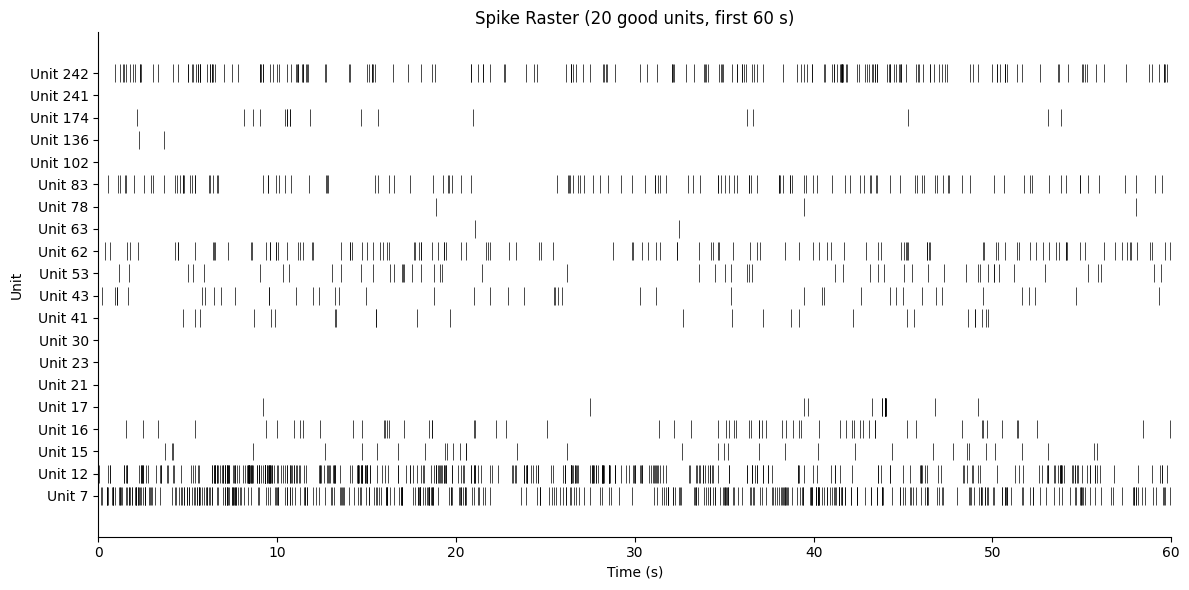

In [15]:
# Select subset of good units to plot
units_to_plot = good_unit_indices[:N_UNITS_TO_PLOT]
n_units = len(units_to_plot)

# Collect spike times using list comprehension
spike_times_list = [
    get_spike_times_in_window(nwbfile.units, idx, TIME_WINDOW) for idx in units_to_plot
]

# Create raster plot
fig, ax = plt.subplots(figsize=(12, 6))

ax.eventplot(
    spike_times_list,
    lineoffsets=np.arange(n_units),
    linelengths=0.8,
    linewidths=0.5,
    colors="black",
)

ax.set(
    xlabel="Time (s)",
    ylabel="Unit",
    xlim=TIME_WINDOW,
    yticks=np.arange(n_units),
    yticklabels=[f"Unit {idx}" for idx in units_to_plot],
    title=f"Spike Raster ({n_units} good units, first {TIME_WINDOW[1]} s)",
)

ax.spines[["top", "right"]].set_visible(False)

plt.tight_layout()
plt.show()

## Extracting Position Data

For navigation studies, we need the animal's position over time. Position data
is stored in the behavior processing module.

In [16]:
# Find position data in the behavior module
behavior_module = nwbfile.processing["behavior"]

print("Available behavior interfaces:")
for name, interface in behavior_module.data_interfaces.items():
    print(f"  - {name}: {type(interface).__name__}")

Available behavior interfaces:
  - Acceleration: TimeSeries
  - SubjectPosition: Position
  - SubjectSpeed: TimeSeries
  - Temperature: TimeSeries


In [17]:
# Extract position data (find interface with "position" in name, case-insensitive)
position_interface = next(
    interface
    for name, interface in behavior_module.data_interfaces.items()
    if "position" in name.lower()
)

print(f"Position interface: {type(position_interface).__name__}")
print(f"\nSpatial series:")
for series_name, spatial_series in position_interface.spatial_series.items():
    print(f"\n  {series_name}:")
    print(f"    Data shape: {spatial_series.data.shape}")
    if spatial_series.rate:
        print(f"    Sampling rate: {spatial_series.rate} Hz")
    elif spatial_series.timestamps is not None:
        print(f"    Timestamps: {len(spatial_series.timestamps)} samples")

Position interface: Position

Spatial series:

  SpatialSeries:
    Data shape: (198664, 3)
    Timestamps: 198664 samples


## Visualizing the Animal's Trajectory

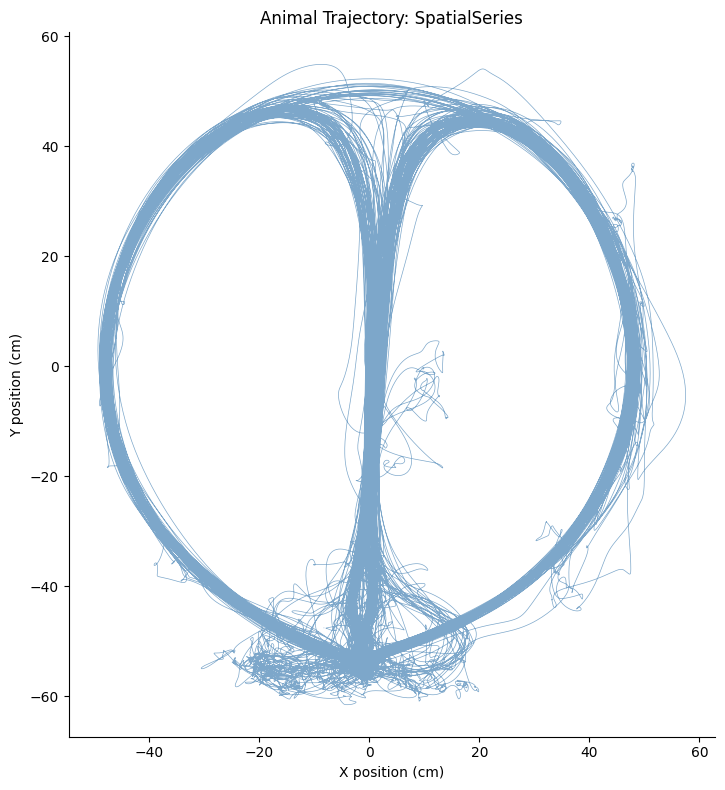

In [18]:
spatial_series = next(iter(position_interface.spatial_series.values()))
position_data = spatial_series.data[:]

x_position, y_position = position_data[:, 0], position_data[:, 1]

fig, ax = plt.subplots(figsize=(8, 8))

ax.plot(x_position, y_position, linewidth=0.5, alpha=0.7, color="steelblue")

ax.set(
    xlabel="X position (cm)",
    ylabel="Y position (cm)",
    title=f"Animal Trajectory: {spatial_series.name}",
    aspect="equal",
)

ax.spines[["top", "right"]].set_visible(False)

plt.tight_layout()
plt.show()

## Speed and Acceleration

Speed and acceleration are often stored alongside position data, or can be
computed from position.

Speed is particularly relevant in hippocampal studies because theta oscillation
frequency and power increase with running speed. In the Petersen & Buzsáki study,
the relationship between movement and theta was central to understanding how
cell assemblies are coordinated.

In [19]:
# Check for speed data (SubjectSpeed in this dataset)
speed_series = next(
    interface
    for name, interface in behavior_module.data_interfaces.items()
    if "speed" in name.lower()
)

print(f"Speed data: {type(speed_series).__name__}")
print(f"  Data shape: {speed_series.data.shape}")
print(f"  Unit: {speed_series.unit}")
if speed_series.rate:
    print(f"  Sampling rate: {speed_series.rate} Hz")

Speed data: TimeSeries
  Data shape: (198664,)
  Unit: cm/s


In [20]:
# Check for acceleration data
acceleration_series = next(
    interface
    for name, interface in behavior_module.data_interfaces.items()
    if "acceleration" in name.lower()
)

print(f"Acceleration data: {type(acceleration_series).__name__}")
print(f"  Data shape: {acceleration_series.data.shape}")
print(f"  Unit: {acceleration_series.unit}")
if acceleration_series.rate:
    print(f"  Sampling rate: {acceleration_series.rate} Hz")

Acceleration data: TimeSeries
  Data shape: (198664,)
  Unit: cm/s^2


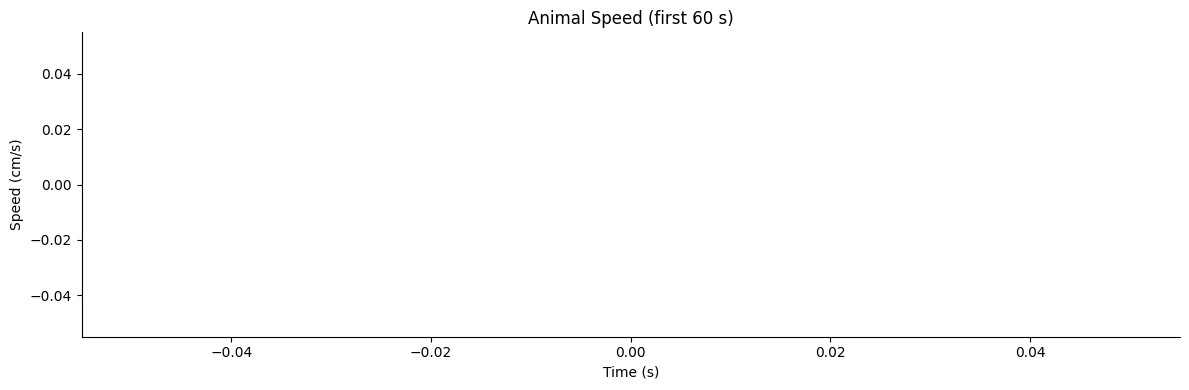

In [21]:
# Visualize speed over time
speed_data = speed_series.data[:]

# Get timestamps
if speed_series.timestamps is not None:
    speed_timestamps = speed_series.timestamps[:]
else:
    speed_timestamps = np.arange(len(speed_data)) / speed_series.rate

# Plot first 60 seconds (relative to start of recording)
t_start = speed_timestamps[0]
time_mask = speed_timestamps < (t_start + 60)

fig, ax = plt.subplots(figsize=(12, 4))

ax.plot(
    speed_timestamps[time_mask] - t_start,
    speed_data[time_mask],
    linewidth=0.5,
    color="steelblue",
)

ax.set(
    xlabel="Time (s)",
    ylabel=f"Speed ({speed_series.unit})",
    title="Animal Speed (first 60 s)",
)

ax.spines[["top", "right"]].set_visible(False)

plt.tight_layout()
plt.show()

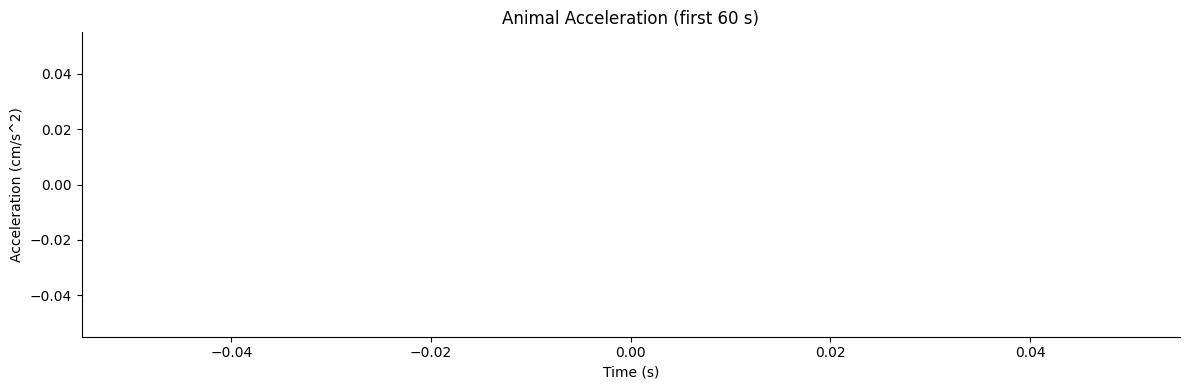

In [22]:
# Visualize acceleration over time
acceleration_data = acceleration_series.data[:]

# Get timestamps
if acceleration_series.timestamps is not None:
    acceleration_timestamps = acceleration_series.timestamps[:]
else:
    acceleration_timestamps = (
        np.arange(len(acceleration_data)) / acceleration_series.rate
    )

# Plot first 60 seconds (relative to start of recording)
t_start = acceleration_timestamps[0]
time_mask = acceleration_timestamps < (t_start + 60)

fig, ax = plt.subplots(figsize=(12, 4))

ax.plot(
    acceleration_timestamps[time_mask] - t_start,
    acceleration_data[time_mask],
    linewidth=0.5,
    color="steelblue",
)

ax.set(
    xlabel="Time (s)",
    ylabel=f"Acceleration ({acceleration_series.unit})",
    title="Animal Acceleration (first 60 s)",
)

ax.spines[["top", "right"]].set_visible(False)

plt.tight_layout()
plt.show()

## Trial Information

Many experiments are organized into trials. NWB stores trial information
in an intervals table with start/stop times and trial-specific metadata.

In this experiment, the animal performed a spatial alternation task on a figure-8
maze, where it had to alternate between left and right choices to receive a reward.
The Petersen & Buzsáki study found that cooling the medial septum increased choice
errors on this task, even though the spatial firing properties of neurons were preserved.

In [23]:
# Check for trials
trials_df = nwbfile.trials.to_dataframe()
print(f"Number of trials: {len(trials_df)}")
print(f"\nTrial table columns:")
for col in trials_df.columns:
    print(f"  - {col}")

print(f"\nFirst 5 trials:")
print(trials_df.head())

Number of trials: 143

Trial table columns:
  - start_time
  - stop_time
  - condition
  - error
  - cooling state

First 5 trials:
    start_time   stop_time condition  error cooling state
id                                                       
0   6357.49870  6360.93190     Right  False   Pre-Cooling
1   6365.92335  6369.13150      Left  False   Pre-Cooling
2   6374.05630  6376.39785     Right  False   Pre-Cooling
3   6380.28935  6382.78090      Left  False   Pre-Cooling
4   6387.08905  6389.48060     Right  False   Pre-Cooling


In [24]:
# Check for other interval tables
if nwbfile.intervals:
    print("Available interval tables:")
    for name, table in nwbfile.intervals.items():
        if name != "trials":  # Already showed trials above
            df = table.to_dataframe()
            print(f"\n  {name}: {len(df)} intervals")
            print(f"    Columns: {list(df.columns)}")

Available interval tables:


## Accessing LFP Data (Separate File)

In this dataset, the LFP (Local Field Potential) data is stored in a separate
NWB file (`*_desc-raw_ecephys.nwb`) due to its large size. This is a common
practice to keep processed data files manageable.

Let's demonstrate how to access the LFP file for this session.

In [25]:
# The LFP file for this session
LFP_ASSET_PATH = (
    "sub-MS22/" "sub-MS22_ses-Peter-MS22-180629-110319-concat_desc-raw_ecephys.nwb"
)

# Get streaming URL for LFP file
with DandiAPIClient() as client:
    dandiset = client.get_dandiset(DANDISET_ID, DANDISET_VERSION)
    lfp_asset = dandiset.get_asset_by_path(LFP_ASSET_PATH)
    lfp_s3_url = lfp_asset.get_content_url(follow_redirects=1, strip_query=True)

print(f"LFP file: {LFP_ASSET_PATH}")
print(f"Streaming from: {lfp_s3_url[:80]}...")

LFP file: sub-MS22/sub-MS22_ses-Peter-MS22-180629-110319-concat_desc-raw_ecephys.nwb
Streaming from: https://dandiarchive.s3.amazonaws.com/blobs/5ff/17f/5ff17f89-382d-400b-8501-028f...


In [26]:
# Open the LFP file for streaming
lfp_remote_file = RemoteFile(lfp_s3_url)
lfp_h5_file = h5py.File(lfp_remote_file, "r")
lfp_io = NWBHDF5IO(file=lfp_h5_file, load_namespaces=True)
lfp_nwbfile = lfp_io.read()

print(f"LFP Session: {lfp_nwbfile.identifier}")

LFP Session: 50906443-9caf-41e1-aaa7-c07c4dbede84


In [27]:
# Check what's in the acquisition (raw data typically stored here)
print("Acquisition data:")
for name, data in lfp_nwbfile.acquisition.items():
    print(f"  - {name}: {type(data).__name__}")
    if hasattr(data, "data"):
        print(f"      Shape: {data.data.shape}")
        if hasattr(data, "rate"):
            print(f"      Rate: {data.rate} Hz")

Acquisition data:
  - ElectricalSeries: ElectricalSeries
      Shape: (243000720, 128)
      Rate: 20000.0 Hz


In [28]:
# Load and plot a small segment of LFP from one channel
# Note: We only load a small segment because the full data is very large

lfp_electrical_series = next(iter(lfp_nwbfile.acquisition.values()))

# Load just 2 seconds of data from channel 0 (theta reference might be a good choice)
SAMPLE_DURATION = 2  # seconds
lfp_rate = lfp_electrical_series.rate
n_samples = int(SAMPLE_DURATION * lfp_rate)

# Get theta reference channel if available, otherwise use channel 0
channel_idx = 0
if "theta_reference" in electrodes_df.columns:
    theta_refs = np.nonzero(electrodes_df["theta_reference"].values)[0]
    if len(theta_refs) > 0:
        channel_idx = theta_refs[0]
        print(f"Using theta reference channel: {channel_idx}")

# Load small segment (streaming means we only download what we request)
lfp_segment = lfp_electrical_series.data[:n_samples, channel_idx]
lfp_time = np.arange(n_samples) / lfp_rate

print(f"Loaded {SAMPLE_DURATION}s of LFP from channel {channel_idx}")
print(f"  Shape: {lfp_segment.shape}")
print(f"  Sampling rate: {lfp_rate} Hz")

Using theta reference channel: 6
Loaded 2s of LFP from channel 6
  Shape: (40000,)
  Sampling rate: 20000.0 Hz


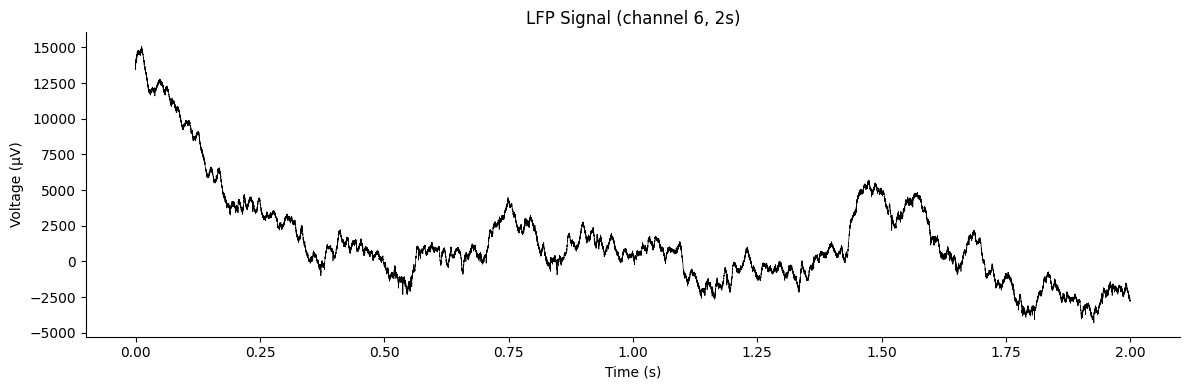

In [29]:
# Plot LFP trace
fig, ax = plt.subplots(figsize=(12, 4))

ax.plot(lfp_time, lfp_segment, linewidth=0.5, color="black")

ax.set(
    xlabel="Time (s)",
    ylabel="Voltage (µV)",
    title=f"LFP Signal (channel {channel_idx}, {SAMPLE_DURATION}s)",
)

ax.spines[["top", "right"]].set_visible(False)

plt.tight_layout()
plt.show()

In [30]:
# Close the LFP file
lfp_io.close()

## Downloading Data Locally (Optional)

For repeated use or offline access, you can download the data:

```bash
pip install dandi
dandi download DANDI:000059/0.230907.2101 --path sub-MS22
```

Then load with:

```python
with NWBHDF5IO("path/to/file.nwb", "r") as io:
    nwbfile = io.read()
    # Work with nwbfile...
```

## Cleanup

In [31]:
# Always close the file when done
io.close()

## Exercises

Try these on your own to practice working with NWB data:

1. **Explore spike times**: Change `TIME_WINDOW` to plot a different 60-second period.
   Do the firing patterns look different?

2. **Count spikes**: How many spikes does each good unit fire in the first 60 seconds?
   (Hint: use `len()` on each element of `spike_times_list`)

3. **Trial statistics**: How many trials are in the full session? What is the average
   trial duration?

4. **Speed distribution**: Plot a histogram of the animal's speed. What is the
   typical running speed?

## Summary

In this notebook, we learned how to:

1. **Stream NWB data from DANDI** without downloading large files
2. **Explore NWB file structure** to discover available data
3. **Inspect electrodes** and recording configuration
4. **Extract and visualize spike times** using `eventplot`
5. **Access position, speed, and acceleration** data
6. **Examine trial structure** from intervals tables

### Key NWB Components

| Component | Description | Access |
|-----------|-------------|--------|
| `nwbfile.electrodes` | Recording electrode metadata | `.to_dataframe()` |
| `nwbfile.electrode_groups` | Electrode groupings (shanks, tetrodes) | dict-like |
| `nwbfile.units` | Sorted spike times | `["spike_times"][idx]` |
| `nwbfile.processing["behavior"]` | Position, speed, acceleration | `.data_interfaces` |
| `nwbfile.trials` | Trial start/stop times and metadata | `.to_dataframe()` |
| `nwbfile.intervals` | Other interval tables | dict-like |

### Python Best Practices Used

- **Pandas DataFrames** for tabular data inspection (via `.to_dataframe()`)
- **List comprehensions** for collecting spike times
- **Generator expressions with `next()`** for finding matching interfaces
- **`next(iter())`** for accessing first item in a collection

### Next Steps

In the next notebook, we'll analyze the relationship between neural activity
and the animal's position. We'll identify **place cells** - neurons that fire
preferentially at specific locations. Recall from the Petersen & Buzsáki paper
that cooling the medial septum preserved these spatial correlates even while
disrupting theta coordination and impairing task performance.